In [1]:
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, DataLoader, Dataset, decollate_batch
from monai.utils import first, set_determinism
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

from pathlib import Path

# from torch.utils.data import Dataset

from pathlib import Path
import os

# from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import numpy as np

import random

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

Fo

In [2]:
import os
import tempfile
directory = os.environ.get("MONAI_DATA_DIRECTORY")
print(directory)
root_dir = Path("/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY")
print(root_dir)
data_dir = os.path.join(root_dir, "Task09_Spleen")

None
/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY


In [2]:
class CTDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image_file = np.load(str(image_filepath))

        path_elements = list(Path(image_filepath).parts)
        index = path_elements.index('scans')
        path_elements[index] = 'airways'

        mask_filepath = os.path.join(*path_elements)
        mask_file = np.load(str(mask_filepath))

        if self.transform is not None:
            transformed_images = []
            transformed_masks = []
            for i in range(0, image_file.shape[-1]):
                
                image_slice = image_file[..., i]
                mask_slice = mask_file[..., i]

                transformed = self.transform(image=image_slice, mask=mask_slice)

                transformed_images.append(transformed["image"])
                transformed_masks.append(transformed["mask"])

            image_file = torch.stack(transformed_images, dim=0)
            mask_file = torch.stack(transformed_masks, dim=0).type(torch.float16)
            mask_file = mask_file.unsqueeze(0)

            image_file = image_file.permute(1, 0, 2, 3)

        return image_file, mask_file

In [3]:
class CTDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
        A.ToFloat(max_value=1024+400, always_apply=True),
        A.Resize(height=64, width=64),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        ToTensorV2()
        ])
        self.transforms = A.Compose([
        A.ToFloat(max_value=1024+400, always_apply=True),
        A.Resize(height=64, width=64),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        ToTensorV2(),
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

        self.path_to_file = '/home/pawel/Documents/RISA/3D_segmentation/dataset'


    def prepare_data(self):
        if os.path.exists(self.path_to_file):
            print("Path exists")
            images_paths = sorted(Path(self.path_to_file).rglob('*.npy'))
            for image_path in images_paths:
                image = np.load(str(image_path))

                if image is None:
                    print("Unlink image: ", image_path)
                    image_path.unlink()
        else:
            print("Path does not exist")


    def setup(self, stage):
        paths = sorted(Path(os.path.join(self.path_to_file, 'scans')).glob('*.npy'))

        self.train_paths, self.val_paths = train_test_split(paths, test_size=0.3, random_state=42)

        self.train_ds = CTDataset(self.train_paths, transform=self.augmentations)
        self.val_ds = CTDataset(self.val_paths, transform=self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train_ds,
                            batch_size=12,
                            shuffle=True,
                            num_workers=6,
                            collate_fn=list_data_collate
                        )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=6, num_workers=6)

## Visualization

Path exists
image shape: torch.Size([32, 64, 64]), label shape: torch.Size([32, 64, 64])


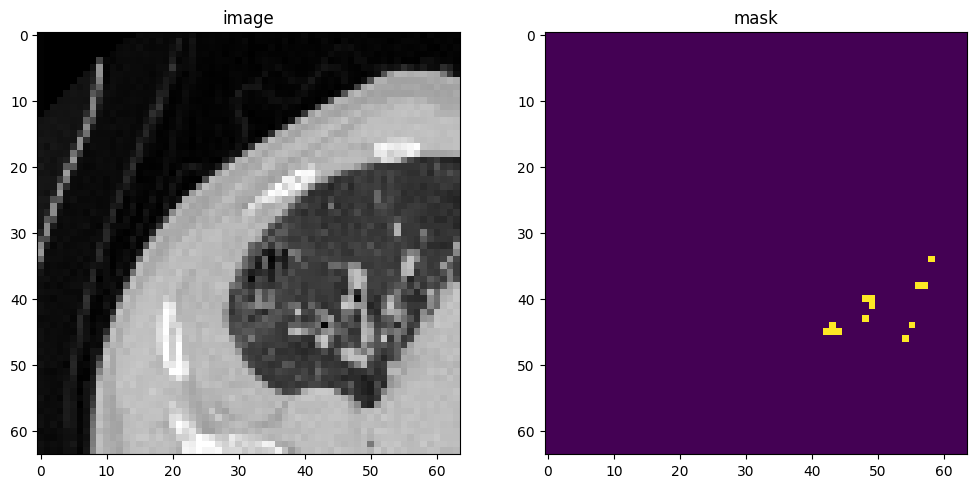

In [6]:
dataModule = CTDataModule()
dataModule.prepare_data()
dataModule.setup('fit')
val_dataset = dataModule.val_ds

object_number = random.randint(0, len(val_dataset)-1)

image, mask = val_dataset.__getitem__(object_number)
image = image.squeeze(0)
mask = mask.squeeze(0)

slice_number = random.randint(0, image.shape[0]-1)

print(f"image shape: {image.shape}, label shape: {mask.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[slice_number, :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("mask")
plt.imshow(mask[slice_number, :, :])
plt.show()

In [4]:
from x_unet import XUnet

class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        )

        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(argmax=True, to_onehot=2)])
        self.post_label = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(to_onehot=2)])
        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.validation_step_outputs = []

    def forward(self, x):
        return self._model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        d = {"val_loss": loss, "val_number": len(outputs)}
        self.validation_step_outputs.append(d)
        return d

    def on_validation_epoch_end(self):
        val_loss, num_items = 0, 0
        for output in self.validation_step_outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.validation_step_outputs.clear()  # free memory
        return {"log": tensorboard_logs}

In [ ]:
# initialise the LightningModule
net = Net()

data_module = CTDataModule()

# set up loggers and checkpoints
log_dir = os.path.join("/home/pawel/Documents/RISA/3D_segmentation", "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)
callbacks_unet=[
    pytorch_lightning.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, save_last=False, verbose=True, dirpath='./checkpoints', filename='epoch_{epoch}-{val_loss:.5f}',  auto_insert_metric_name=False),
    pytorch_lightning.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch'),
],

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    devices=[0],
    max_epochs=600,
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    strategy='ddp_notebook',
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
)
net.eval()
# train
trainer.fit(net, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------



Path exists


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 4.8 M 
1 | loss_function | DiceLoss | 0     
-------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.236    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]current epoch: 0 current mean dice: 0.0060
best mean dice: 0.0060 at epoch: 0
Epoch 0: 100%|██████████| 50/50 [00:03<00:00, 15.07it/s, v_num=3]          current epoch: 0 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 1: 100%|██████████| 50/50 [00:03<00:00, 14.68it/s, v_num=3]current epoch: 1 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 2: 100%|██████████| 50/50 [00:03<00:00, 14.66it/s, v_num=3]current epoch: 2 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 3: 100%|██████████| 50/50 [00:03<00:00, 14.36it/s, v_num=3]current epoch: 3 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 4: 100%|██████████| 50/50 [00:03<00:00, 14.65it/s, v_num=3]current epoch: 4 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 5: 100%|██████████| 50/50 [00:03<00:00, 14.37it/s, v_num=3]current epoch: 5 current mean dice: 0.0000
best mean dice

/home/pawel/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


current epoch: 6 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 7: 100%|██████████| 50/50 [00:03<00:00, 13.56it/s, v_num=3]current epoch: 7 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 8: 100%|██████████| 50/50 [00:03<00:00, 13.89it/s, v_num=3]current epoch: 8 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 9: 100%|██████████| 50/50 [00:03<00:00, 13.52it/s, v_num=3]current epoch: 9 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 10: 100%|██████████| 50/50 [00:03<00:00, 13.51it/s, v_num=3]current epoch: 10 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 11: 100%|██████████| 50/50 [00:03<00:00, 13.45it/s, v_num=3]current epoch: 11 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 12: 100%|██████████| 50/50 [00:03<00:00, 13.52it/s, v_num=3]current epoch: 12 current mean dice: 0.0000
best mean dice: 0.0060 at epoch: 0
Epoch 13: 100%|██████████| 50/50 [00:03<00:00, 14.09it/s, 

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)

In [22]:
import nibabel as nib

img = nib.load('/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY/Task09_Spleen/imagesTr/spleen_2.nii.gz')

print("type of images and labels:", type(img))
print("shapes of images and labels:", img.shape)
# print(images)

type of images and labels: <class 'nibabel.nifti1.Nifti1Image'>
shapes of images and labels: (512, 512, 90)
